# Description

This notebooks uses the calendar and probability distributions to calculate/create a table of outputs showing the expected number of "Natural" counts one would expect to see over three different time scales---annual, seasonal (3 months), and monthly---given a particularly chosen percentile.

The resulting numbers are printed to create Supporting Information Table S2, and the counts are saved into **[Ndays_Expected.nc](./data/analysis/Ndays_Expected.nc)** for use in the attribution analyses (see XXXXXXXXX).

**TABLES PRODUCED IN THIS CODE**
* Table S2

In [1]:
import numpy as np
import pandas as pd
from calendar import monthrange
import matplotlib.pyplot as plt
import xarray as xr
import os

### Definitions -- Percentiles and Time Periods

Time scales considered:
* Annual (1 year: 365 days)
* Seasonal (3 months: DJF, MAM, JJA, SON; ndays vary by months included)
* Monthly (ndays vary by month)

Percentiles explored:
* 99.99, 99.9, 99, 98, 97.5, 97, 96, ..., 50
* 0.01, 0.1, 1, 2, 2.5, 3, 4, 5, ..., 49

In [2]:
# define the percentile grids
midgrid=np.arange(3,96+1,1)
lowgrid=np.asarray([0.01,0.1,1,2,2.5])
highgrid=np.flip(100-lowgrid)
# combine them into a single grid
pgrid=np.concatenate((lowgrid,midgrid,highgrid))
print(pgrid[:10])
print(pgrid[-10:])
npc=len(pgrid)

[0.01 0.1  1.   2.   2.5  3.   4.   5.   6.   7.  ]
[92.   93.   94.   95.   96.   97.5  98.   99.   99.9  99.99]


In [3]:
# define the number of days in each month (ignore leap years)
mondays=np.asarray([monthrange(2011, i)[1] for i in np.arange(12)+1])

# get the number of days in a year
ndays_yr=np.sum(mondays)

# get the number of days in each season (DJF, MAM, JJA, SON), by shifting mondays 1 month
ndays_seas=np.asarray([np.sum(np.roll(mondays,1)[i:i+3]) for i in np.arange(0,10,3)])


## Find the number of Expected counts in a season, by percentile

The expected number of counts for a specific period is by the definition of the percentile, where the ordinal rank ($n_{rank}$) is given by the percentile between 0 and 100, $p$, and the number of values in the ordered list ($N$):

$ n_{rank} = \frac{p}{100} \times N$

For our purposes, the number of values in our list corresponds to the number of days we are analyzing over, i.e. $N \equiv n_{days}$:

$ n_{rank,day} = \frac{p}{100} \times (n_{days})$

So that, through the definition of the ordinal rank, the total of number of days which will exceed it ($n_{exceedances}$), based on the percentile, is given by:

$n_{exceedances} = n_{days} - n_{rank,day} = n_{days} - \frac{p}{100} \times (n_{days}) $

#### Example

Let's assume that we are searching for the threshold for the number of exceedances of the defined percentile threshold, if $p=95$ and our time period is annual ($n_{days}=365$).

#### Subceedance

If we are looking for the number of values _under_ the threshold, we would find the subceedance, which is equal to the number of days in our period MINUS the threshold number, i.e. 
$n_{subceedances} =  n_{days} - n_{exceedances}$ , which is identically $n_{rank,day}$.

NOTE: The unit of $n_{exceedances}$/$n_{subceedances}$ always matches that of the counts in your list (annual is number of days)

In [4]:
# Functions to calculate the natural thresholds associated with a list of values
def nat_exceed(pp,ndays):
    # pp is the percentile over 0-100
    # ndays in the number of values in your list (usually number of days)
    nexceed=ndays-(pp/100)*ndays
    return(nexceed)

def nat_subceed(pp,ndays):
    # pp is the percentile over 0-100
    # ndays in the number of values in your list (usually number of days)
    nsubceed=(pp/100)*ndays
    return(nsubceed)

In [5]:
p1=95
n1=nat_exceed(p1,ndays_yr)
n2=nat_subceed(p1,ndays_yr)
print(n1)
print(n2)

18.25
346.75


So all together, for the 95th percentile we would expect there to be exactly 18.25 days which would meet or exceed this percentile over a representative 365 day period. Meanwhile, the number of days at or below that threshold is 346.75.

## Create the Grids

In [6]:
# create an annual grid of exceedances
annual_exceed=np.empty((npc,),dtype='float')
annual_exceed[:,]=nat_exceed(pgrid,ndays_yr)
annual_subceed=np.empty((npc,),dtype='float')
annual_subceed[:,]=nat_subceed(pgrid,ndays_yr)

# create a monthly and seasonal grid
mon_exceed=np.empty((npc,len(mondays)),dtype='float')
mon_subceed=np.empty((npc,len(mondays)),dtype='float')
seas_exceed=np.empty((npc,len(ndays_seas)),dtype='float')
seas_subceed=np.empty((npc,len(ndays_seas)),dtype='float')
for pp,p0 in enumerate(pgrid):
    seas_exceed[pp,:]=nat_exceed(p0,ndays_seas)
    mon_exceed[pp,:]=nat_exceed(p0,mondays)
    seas_subceed[pp,:]=nat_subceed(p0,ndays_seas)
    mon_subceed[pp,:]=nat_subceed(p0,mondays)

For sanity, check the average of the expected number of days in a season (should be ~90 days).

In [7]:
np.mean(ndays_seas)

91.25

## Quick Look at the results

In [8]:
print(pgrid[92])
print(np.mean(mondays))
print(np.mean(mon_exceed[92,:]))

print(pgrid[97])
print(np.mean(mon_exceed[97,:]))

print(pgrid[99])
print(np.mean(mon_exceed[99,:]))

print(pgrid[101])
print(np.mean(mon_exceed[101,:]))

90.0
30.416666666666668
3.0416666666666656
95.0
1.520833333333334
97.5
0.7604166666666679
99.0
0.30416666666666625


In [9]:
print(pgrid[92])
print(np.mean(ndays_seas))
print(np.mean(seas_exceed[92,:]))

print(pgrid[97])
print(np.mean(seas_exceed[97,:]))

print(pgrid[99])
print(np.mean(seas_exceed[99,:]))

print(pgrid[101])
print(np.mean(seas_exceed[101,:]))

90.0
91.25
9.125
95.0
4.5625000000000036
97.5
2.28125
99.0
0.9125000000000014


In [10]:
print(pgrid[92])
print(np.mean(365))
print(np.mean(annual_exceed[92]))

print(pgrid[97])
print(np.mean(annual_exceed[97]))

print(pgrid[99])
print(np.mean(annual_exceed[99]))

print(pgrid[101])
print(np.mean(annual_exceed[101]))

90.0
365.0
36.5
95.0
18.25
97.5
9.125
99.0
3.6499999999999773


# Create/Show Table S2

#### Aggregate Data

In [11]:
q90_dict={
    '30 (Month)': [np.mean(mon_exceed[92])],
    '91 (Season)': [np.mean(seas_exceed[92])],
    '365 (Year)': [np.mean(annual_exceed[92])],
         }
q90df=pd.DataFrame(q90_dict,index={'qi=0.90'})
q95_dict={
    '30 (Month)': np.mean(mon_exceed[97]),
    '91 (Season)': np.mean(seas_exceed[97]),
    '365 (Year)': np.mean(annual_exceed[97]),
         }
q95df=pd.DataFrame(q95_dict,index={'qi=0.95'})
q975_dict={
    '30 (Month)': np.mean(mon_exceed[99]),
    '91 (Season)': np.mean(seas_exceed[99]),
    '365 (Year)': np.mean(annual_exceed[99]),
         }
q975df=pd.DataFrame(q975_dict,index={'qi=0.975'})
q99_dict={
    '30 (Month)': np.mean(mon_exceed[101]),
    '91 (Season)': np.mean(seas_exceed[101]),
    '365 (Year)': np.mean(annual_exceed[101]),
         }
q99df=pd.DataFrame(q99_dict,index={'qi=0.99'})

#### Print

In [12]:
display(q90df)
display(q95df)
display(q975df)
display(q99df)

,30 (Month),91 (Season),365 (Year)
qi=0.90,3.041667,9.125,36.5


,30 (Month),91 (Season),365 (Year)
qi=0.95,1.520833,4.5625,18.25


,30 (Month),91 (Season),365 (Year)
qi=0.975,0.760417,2.28125,9.125


,30 (Month),91 (Season),365 (Year)
qi=0.99,0.304167,0.9125,3.65


# Save out the results

We will store the result in an xarray dataset and then save out the data to a netcdf that can be read throughout the attribution analysis codebase.

In [13]:
# define monthly period labels
seaslabels=['DJF','MAM','JJA','SON']
monlabels=['J','F','M','A','M','J','J','A','S','O','N','D']

In [14]:
dso=xr.Dataset(
    {
        'AnnualExceedance': (['pp'], annual_exceed),
        'AnnualSubceedance': (['pp'], annual_subceed),
        'SeasonalExceedance': (['pp','seas'], seas_exceed),
        'SeasonalSubceedance': (['pp','seas'], seas_subceed),
        'MonthlyExceedance': (['pp','mon'], mon_exceed),
        'MonthlySubceedance': (['pp','mon'], mon_subceed),
    },
    coords={
        'pp': (['pp'], pgrid.squeeze()),
        'seas': (['seas'], seaslabels),
        'mon': (['mon'], monlabels)
    },
    attrs={
        'Dataset Unit': 'Number of Days Equal to or Exceeding OR Subceeding the percentile'
    }
)

In [15]:
# save out the result
savepath='./data/analysis/'
savename='Ndays_Expected.nc'
# remove the file if it already exists
if os.path.exists(savepath+savename):
    os.remove(savepath+savename)
# the save the result
dso.to_netcdf(savepath+savename)


---

# Plot the results

The following analyses are for illustrative/intuition-building purposes only.

### Annual

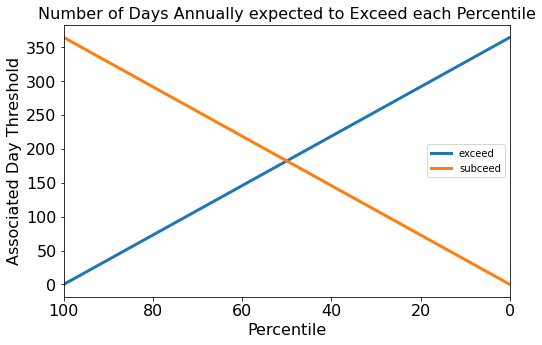

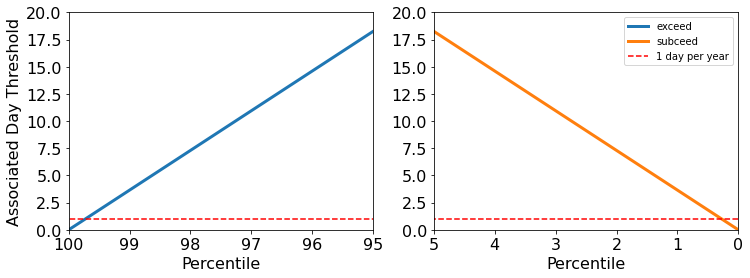

In [16]:
plt.figure(figsize=(8,5))
plt.plot(pgrid,annual_exceed,lw=3,label='exceed')
plt.plot(pgrid,annual_subceed,lw=3,label='subceed')
plt.xlim([100,0])
plt.xlabel('Percentile',fontsize=16)
plt.ylabel('Associated Day Threshold',fontsize=16)
plt.title('Number of Days Annually expected to Exceed each Percentile',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(pgrid,annual_exceed,lw=3,label='exceed')
plt.plot(pgrid,annual_subceed,lw=3,label='subceed')
plt.xlim([100,95])
plt.ylim([0,20])
plt.xlabel('Percentile',fontsize=16)
plt.ylabel('Associated Day Threshold',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.hlines(1,0,100,color='r',linestyle='--')

plt.subplot(1,2,2)
plt.plot(pgrid,annual_exceed,lw=3,label='exceed')
plt.plot(pgrid,annual_subceed,lw=3,label='subceed')
plt.xlim([5,0])
plt.ylim([0,20])
plt.xlabel('Percentile',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.hlines(1,0,100,color='r',linestyle='--',label='1 day per year')

plt.legend()
plt.show()

### Seasonal

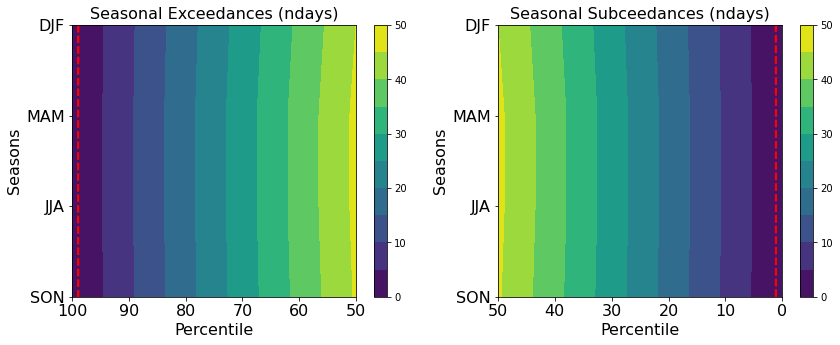

In [17]:
plt.figure(figsize=(14,5))
clevels=np.arange(0,55,5)

plt.subplot(1,2,1)
c1=plt.contourf(pgrid,np.arange(4),seas_exceed.T,levels=clevels)
plt.contour(pgrid,np.arange(4),seas_exceed.T,colors='r',linewidths=2,linestyles='--',levels=[0.99,1.01])
plt.yticks(np.arange(4),seaslabels)
plt.colorbar(c1)
plt.xlim([100,50])
plt.ylim([3,0])
plt.xlabel('Percentile',fontsize=16)
plt.ylabel('Seasons',fontsize=16)
plt.title('Seasonal Exceedances (ndays)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1,2,2)
c2=plt.contourf(pgrid,np.arange(4),seas_subceed.T,levels=clevels)
plt.contour(pgrid,np.arange(4),seas_subceed.T,colors='r',linewidths=2,linestyles='--',levels=[0.99,1.01])
plt.yticks(np.arange(4),seaslabels)
plt.colorbar(c2)
plt.xlim([50,0])
plt.ylim([3,0])
plt.xlabel('Percentile',fontsize=16)
plt.ylabel('Seasons',fontsize=16)
plt.title('Seasonal Subceedances (ndays)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

### Monthly

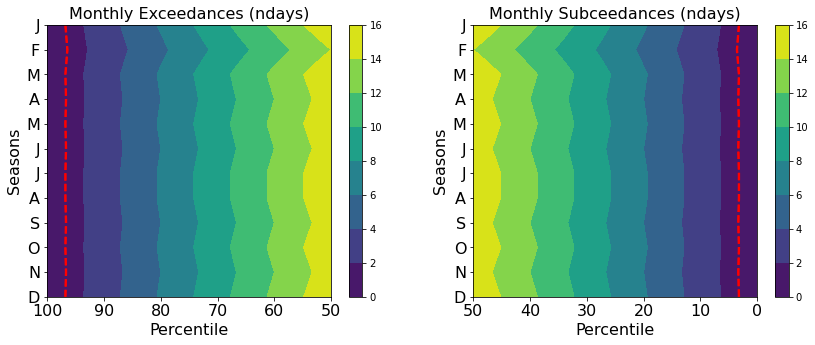

In [18]:
plt.figure(figsize=(14,5))
clevels=np.arange(0,16+1,2)

plt.subplot(1,2,1)
c1=plt.contourf(pgrid,np.arange(12),mon_exceed.T,levels=clevels)
plt.contour(pgrid,np.arange(12),mon_exceed.T,colors='r',linewidths=2,linestyles='--',levels=[0.99,1.01])
plt.yticks(np.arange(12),monlabels)
plt.colorbar(c1)
plt.xlim([100,50])
plt.ylim([11,0])
plt.xlabel('Percentile',fontsize=16)
plt.ylabel('Seasons',fontsize=16)
plt.title('Monthly Exceedances (ndays)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1,2,2)
c2=plt.contourf(pgrid,np.arange(12),mon_subceed.T,levels=clevels)
plt.contour(pgrid,np.arange(12),mon_subceed.T,colors='r',linewidths=2,linestyles='--',levels=[0.99,1.01])
plt.yticks(np.arange(12),monlabels)
plt.colorbar(c2)
plt.xlim([50,0])
plt.ylim([11,0])
plt.xlabel('Percentile',fontsize=16)
plt.ylabel('Seasons',fontsize=16)
plt.title('Monthly Subceedances (ndays)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()